In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, TimeDistributed, RepeatVector, Reshape, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D

# Data preparation

## Upload data

In [3]:
FOLDER_PATH = "./drive/MyDrive/ColabData/IS-data/"

In [4]:
df = pd.concat([pd.read_csv(FOLDER_PATH + "DailyDelhiClimateTrain.csv"), pd.read_csv(FOLDER_PATH + "DailyDelhiClimateTest.csv")])

In [5]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by=["date"], inplace=True)

## Explore data for possible empty values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1576 non-null   datetime64[ns]
 1   meantemp      1576 non-null   float64       
 2   humidity      1576 non-null   float64       
 3   wind_speed    1576 non-null   float64       
 4   meanpressure  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 73.9 KB


In [7]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


We see that meanpresure column has some values that are to big or to small. Decide to replace those with mean of the column.

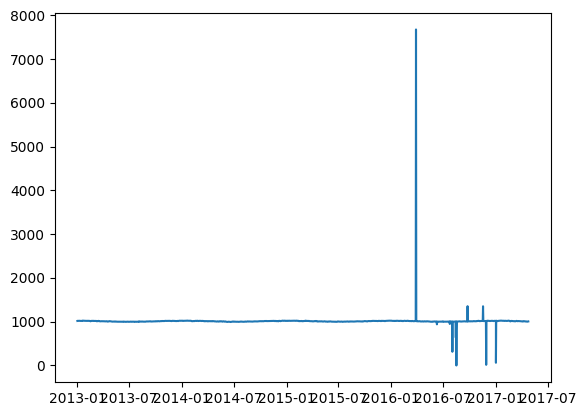

In [8]:
plt.plot(df["date"], df["meanpressure"])

In [9]:
mean = df["meanpressure"].astype("float").mean()
df["meanpressure"].mask(df["meanpressure"] > 1100, mean, inplace=True)
df["meanpressure"].mask(df["meanpressure"] < 980, mean, inplace=True)

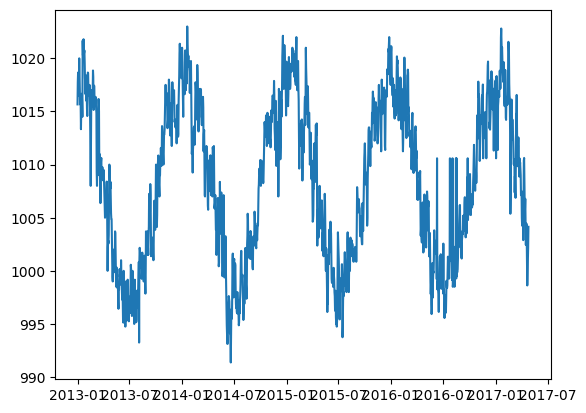

In [10]:
plt.plot(df["date"], df["meanpressure"])

## Plot the correlation matrix

<ipython-input-11-bd08e0cb5eb5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=fig.number)


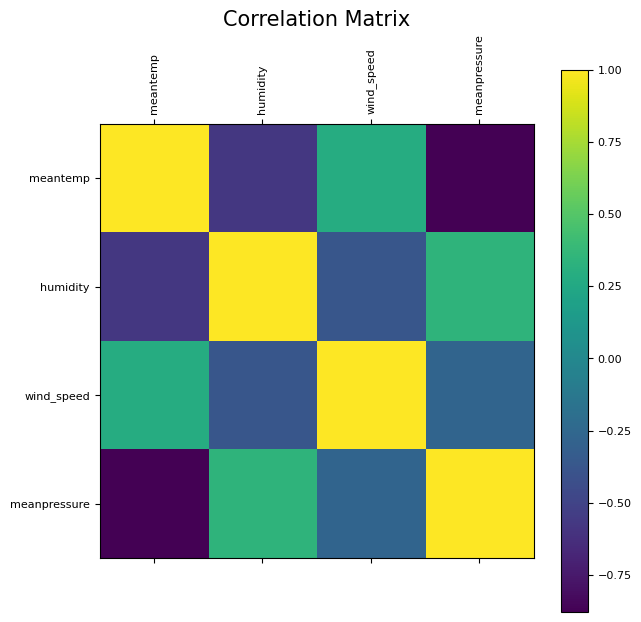

In [11]:
fig = plt.figure(figsize=(7, 7))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=15);

# Develop and train models

## Univariate Conv1d models

In [12]:
def evaluate_forecasts(actual, predicted):
    rmse_by_day = [np.sqrt(mean_squared_error(actual[:, i], predicted[:, i])) for i in range(actual.shape[1])]
    overall_rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"\n----------------------\n\nOverall RMSE: {overall_rmse}\nRMSE by forecast step: {rmse_by_day}")
    return overall_rmse, rmse_by_day

In [13]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_values[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], values.shape[1], 1))
    return values, labels

In [14]:
def build_and_fit_model(model_func, train, n_input, epochs, batch_size):
    X_train, y_train = create_windows(train, n_input)
    model = model_func(X_train.shape[1], X_train.shape[2], y_train.shape[1])
    model.compile(loss='mse', optimizer='adam')
    verbose = 1
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [15]:
def forecast(model, test, n_input):
    X_test, y_test = create_windows(test, n_input)
    y_pred = model.predict(X_test, verbose=1)
    score, scores = evaluate_forecasts(y_test, y_pred)
    return y_pred, score, scores

In [16]:
def evaluate_model(model_func, train, test, n_input, epochs=10, batch_size=16):
    model = build_and_fit_model(model_func, train, n_input, epochs, batch_size)
    return forecast(model, test, n_input)

### Split data into train and test datasets

In [17]:
def split_dataframe(dataframe, split):
    train, test = np.split(dataframe, [int(split*len(dataframe))])
    return train, test

In [18]:
meantemp_train, meantemp_test = split_dataframe(df["meantemp"], 0.75)

In [19]:
def plot_results_by_step(y_df, y_pred):
    _, y_actual = create_windows(y_df, 7)
    fig, axs = plt.subplots(2, 4)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.delaxes(axs[1,3])
    j = 0
    for ax in axs.flatten()[:-1]:
        ax.set_title(f'{j+1} step')
        ax.plot(y_actual[:, j], label='Real temperature')
        ax.plot(y_pred[:, j], label='Predicted temperature')
        j += 1
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
    fig.tight_layout()

### Univariate LSTM-Conv1D

In [20]:
def build_uni_lstm_conv1d(n_timesteps, n_features, n_outputs):
    return Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        RepeatVector(n_outputs),
        LSTM(100, activation='relu', return_sequences=True),
        TimeDistributed(Dense(50, activation='relu')),
        TimeDistributed(Dense(1)),
        Reshape((n_outputs,))
    ])

In [21]:
uni_lstm_conv1d_preds, uni_lstm_conv1d_rmse, uni_lstm_conv1d_rmse_by_day = evaluate_model(build_uni_lstm_conv1d, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 8s 34ms/step - loss: 37.8399
Epoch 2/10
73/73 [==============================] - 3s 36ms/step - loss: 8.0891
Epoch 3/10
73/73 [==============================] - 3s 42ms/step - loss: 7.3179
Epoch 4/10
73/73 [==============================] - 3s 45ms/step - loss: 6.9081
Epoch 5/10
73/73 [==============================] - 3s 36ms/step - loss: 6.7456
Epoch 6/10
73/73 [==============================] - 3s 38ms/step - loss: 6.6766
Epoch 7/10
73/73 [==============================] - 2s 27ms/step - loss: 6.9483
Epoch 8/10
73/73 [==============================] - 1s 17ms/step - loss: 6.4739
Epoch 9/10
73/73 [==============================] - 1s 17ms/step - loss: 6.2063
Epoch 10/10
12/12 [==============================] - 0s 7ms/step

----------------------

Overall RMSE: 2.869435709488593
RMSE by forecast step: [2.0290647407023696, 2.535065053992836, 3.0198423649388464, 3.411460435892248, 3.1850086993538693, 2.9125944274163107, 2.7761436486548

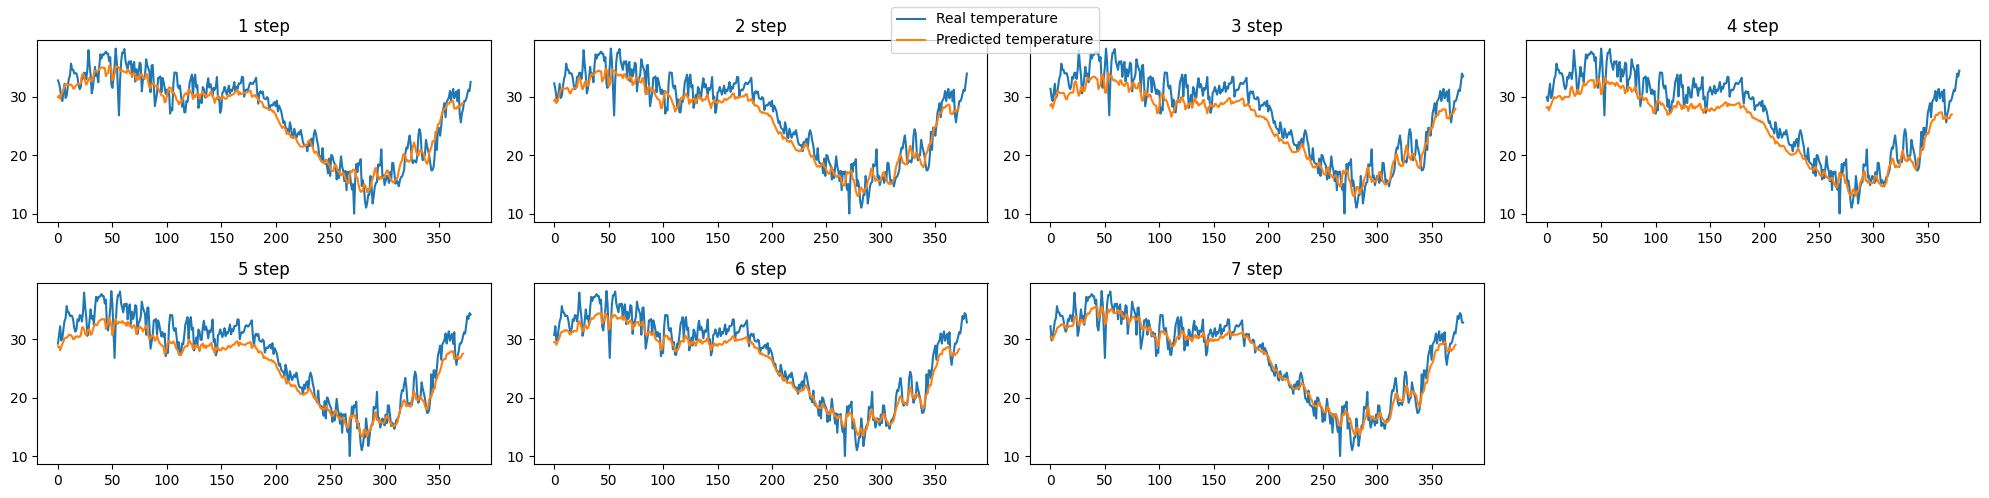

In [22]:
plot_results_by_step(meantemp_test, uni_lstm_conv1d_preds)

### Univariate GRU-Conv1D

In [23]:
def build_uni_gru_conv1d(n_timesteps, n_features, n_outputs):
    return Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        RepeatVector(n_outputs),
        GRU(100, activation='relu', return_sequences=True),
        TimeDistributed(Dense(50, activation='relu')),
        TimeDistributed(Dense(1)),
        Reshape((n_outputs,))
    ])

In [24]:
uni_gru_conv1d_preds, uni_gru_conv1d_rmse, uni_gru_conv1d_rmse_by_day = evaluate_model(build_uni_gru_conv1d, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 3s 16ms/step - loss: 43.7223
Epoch 2/10
73/73 [==============================] - 2s 21ms/step - loss: 7.1262
Epoch 3/10
73/73 [==============================] - 2s 29ms/step - loss: 6.7851
Epoch 4/10
73/73 [==============================] - 2s 28ms/step - loss: 6.4841
Epoch 5/10
73/73 [==============================] - 1s 16ms/step - loss: 6.3714
Epoch 6/10
73/73 [==============================] - 1s 15ms/step - loss: 6.4559
Epoch 7/10
73/73 [==============================] - 1s 16ms/step - loss: 6.0530
Epoch 8/10
73/73 [==============================] - 1s 16ms/step - loss: 6.1895
Epoch 9/10
73/73 [==============================] - 1s 15ms/step - loss: 6.2239
Epoch 10/10
12/12 [==============================] - 0s 6ms/step

----------------------

Overall RMSE: 2.5065295970791848
RMSE by forecast step: [1.9333408482854222, 2.2525432025706644, 2.450371635342694, 2.572776702029608, 2.643847279852678, 2.7421604727396183, 2.8344669736835

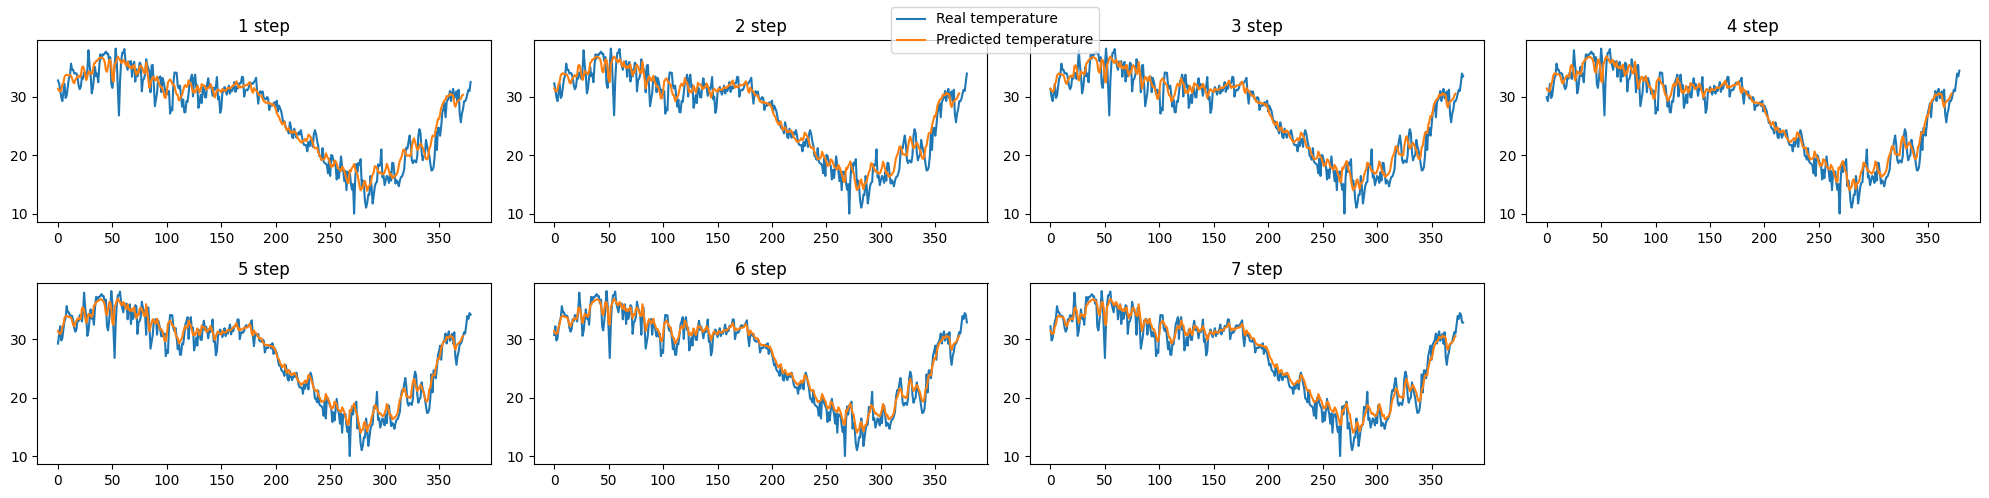

In [25]:
plot_results_by_step(meantemp_test, uni_gru_conv1d_preds)

## Multivariate Conv1d models

In [26]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    df_labels = np.array(dataframe["meantemp"].values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_labels[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], values.shape[1], 4))
    return values, labels

In [27]:
df_train, df_test = split_dataframe(df[["meantemp", "humidity", "wind_speed", "meanpressure"]], 0.75)

### Multivariate LSTM Conv1d

In [28]:
multi_lstm_conv1d_preds, _, _ = evaluate_model(build_uni_lstm_conv1d, df_train, df_test, 14, epochs=50)

Epoch 1/50
73/73 [==============================] - 3s 17ms/step - loss: 386.3372
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 56.5405
Epoch 3/50
73/73 [==============================] - 1s 16ms/step - loss: 48.9002
Epoch 4/50
73/73 [==============================] - 2s 22ms/step - loss: 42.2763
Epoch 5/50
73/73 [==============================] - 2s 31ms/step - loss: 43.8358
Epoch 6/50
73/73 [==============================] - 2s 27ms/step - loss: 45.3933
Epoch 7/50
73/73 [==============================] - 1s 17ms/step - loss: 31.9606
Epoch 8/50
73/73 [==============================] - 1s 16ms/step - loss: 33.9347
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 22.4374
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 21.7805
Epoch 11/50
73/73 [==============================] - 1s 17ms/step - loss: 19.1274
Epoch 12/50
73/73 [==============================] - 1s 17ms/step - loss: 19.7248
Epoch 13/50
73/73 [=====

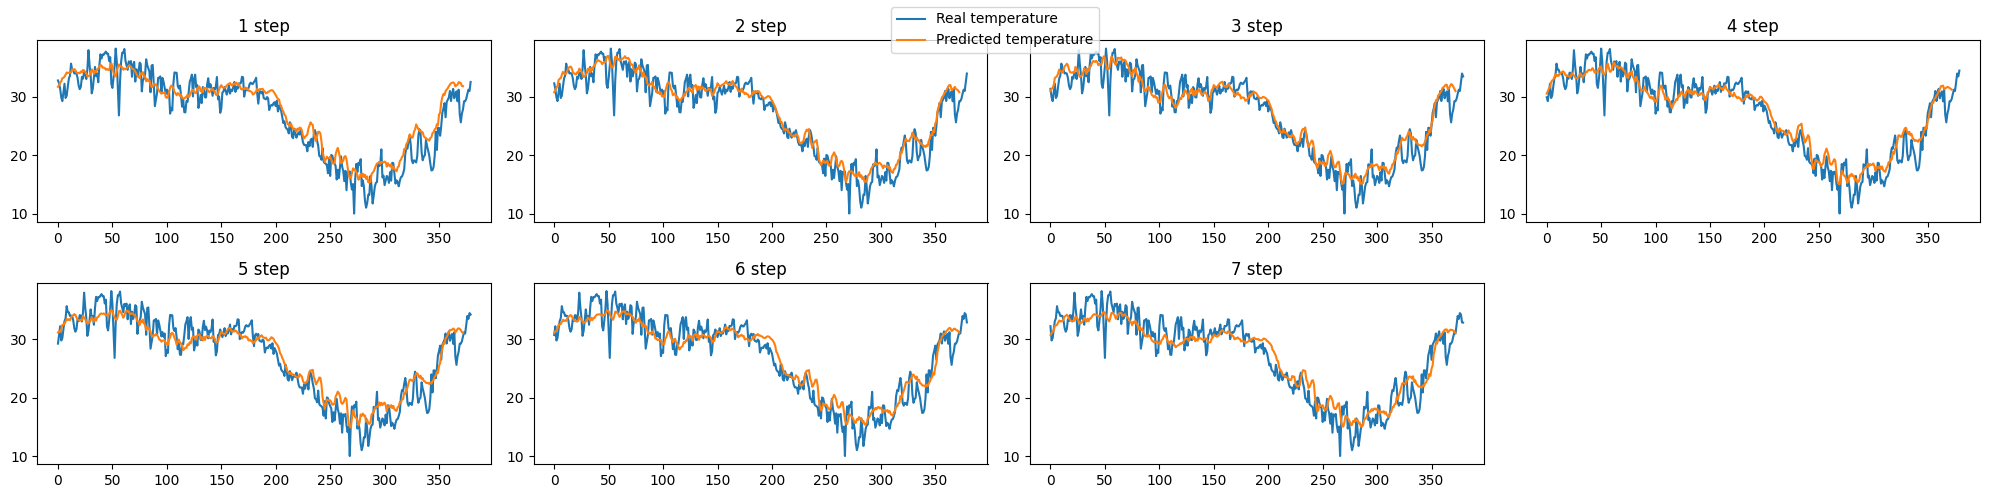

In [29]:
plot_results_by_step(df_test, multi_lstm_conv1d_preds)

### Multivariate gru Conv1d

In [30]:
multi_gru_conv1d_preds, _, _ = evaluate_model(build_uni_gru_conv1d, df_train, df_test, 14, epochs=50)

Epoch 1/50
73/73 [==============================] - 5s 30ms/step - loss: 174.2797
Epoch 2/50
73/73 [==============================] - 2s 30ms/step - loss: 60.3898
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 42.4421
Epoch 4/50
73/73 [==============================] - 1s 16ms/step - loss: 30.5369
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 33.9513
Epoch 6/50
73/73 [==============================] - 1s 16ms/step - loss: 25.1094
Epoch 7/50
73/73 [==============================] - 1s 16ms/step - loss: 22.5651
Epoch 8/50
73/73 [==============================] - 1s 16ms/step - loss: 19.7123
Epoch 9/50
73/73 [==============================] - 1s 16ms/step - loss: 16.0312
Epoch 10/50
73/73 [==============================] - 1s 16ms/step - loss: 15.6650
Epoch 11/50
73/73 [==============================] - 2s 21ms/step - loss: 16.7678
Epoch 12/50
73/73 [==============================] - 2s 29ms/step - loss: 15.5975
Epoch 13/50
73/73 [=====

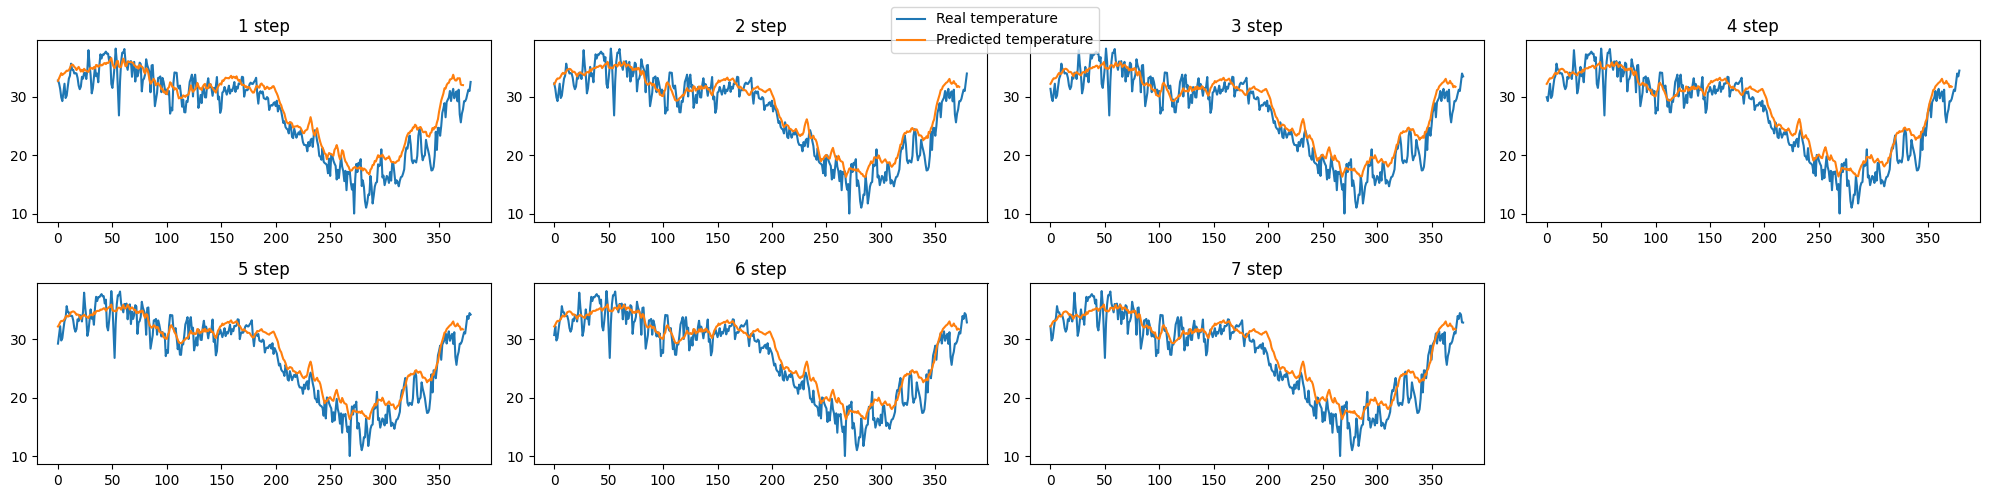

In [31]:
plot_results_by_step(df_test, multi_gru_conv1d_preds)

## ConvLSTM models

In [32]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_values[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], 1, 1, values.shape[1], 1))
    return values, labels

In [33]:
def build_and_fit_model(model_func, train, n_input, epochs, batch_size):
    X_train, y_train = create_windows(train, n_input)
    model = model_func(X_train.shape[3], X_train.shape[4], y_train.shape[1])
    model.compile(loss='mse', optimizer='adam')
    verbose = 1
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

### Univariate ConvLSTM

In [34]:
def build_uni_convlstm(n_timesteps, n_features, n_outputs):
    return Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=(1, 1, n_timesteps, n_features)),
        Flatten(),
        RepeatVector(n_outputs),
        GRU(100, activation='relu', return_sequences=True),
        TimeDistributed(Dense(50, activation='relu')),
        TimeDistributed(Dense(1)),
        Reshape((n_outputs,))
    ])

In [35]:
uni_convlstm_preds, _, _ = evaluate_model(build_uni_convlstm, meantemp_train, meantemp_test, 14)

Epoch 1/10
73/73 [==============================] - 8s 27ms/step - loss: 108.8963
Epoch 2/10
73/73 [==============================] - 2s 27ms/step - loss: 8.6244
Epoch 3/10
73/73 [==============================] - 2s 26ms/step - loss: 7.4526
Epoch 4/10
73/73 [==============================] - 2s 27ms/step - loss: 7.2835
Epoch 5/10
73/73 [==============================] - 2s 31ms/step - loss: 6.2447
Epoch 6/10
73/73 [==============================] - 4s 48ms/step - loss: 6.4382
Epoch 7/10
73/73 [==============================] - 2s 30ms/step - loss: 6.0049
Epoch 8/10
73/73 [==============================] - 2s 27ms/step - loss: 5.9689
Epoch 9/10
73/73 [==============================] - 2s 28ms/step - loss: 5.8130
Epoch 10/10
12/12 [==============================] - 1s 10ms/step

----------------------

Overall RMSE: 2.446934217811468
RMSE by forecast step: [1.9305036595759684, 2.1986848833020862, 2.382832691998908, 2.5167101485797683, 2.601747509168004, 2.667490614134738, 2.730390444679

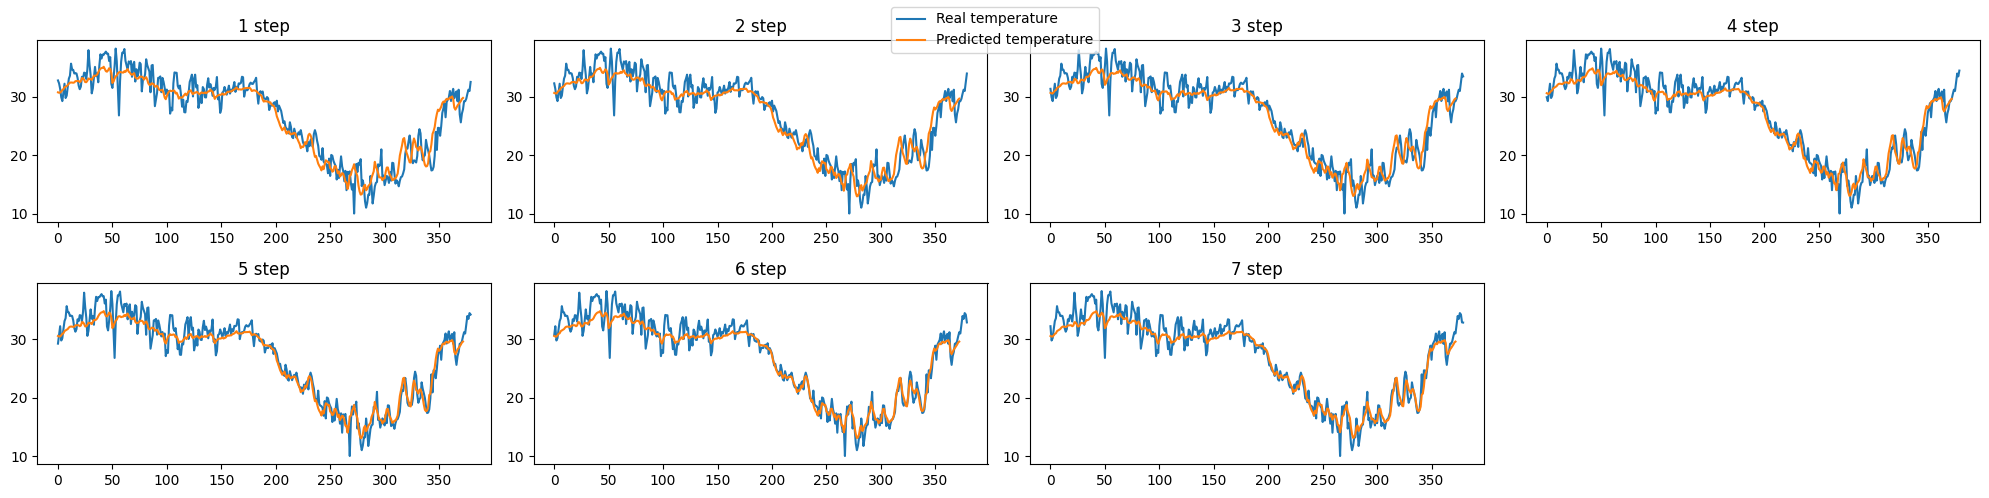

In [36]:
plot_results_by_step(meantemp_test, uni_convlstm_preds)

### Multivariate ConvLSTM

In [37]:
def create_windows(dataframe, n_input, n_output=7):
    df_values = np.array(dataframe.values)
    df_labels = np.array(dataframe["meantemp"].values)
    len_df = len(df_values)
    values, labels = [], []
    for i in range(n_input, len_df - n_output):
        values.append(df_values[i-n_input:i])
        labels.append(df_labels[i:i+n_output])
    values, labels = np.array(values, dtype="float"), np.array(labels, dtype="float")
    values=np.reshape(values,(values.shape[0], 1, 1, values.shape[1], 4))
    return values, labels

In [38]:
multi_convlstm_preds, _, _ = evaluate_model(build_uni_convlstm, df_train, df_test, 14)

Epoch 1/10
73/73 [==============================] - 8s 27ms/step - loss: 53.1670
Epoch 2/10
73/73 [==============================] - 2s 28ms/step - loss: 22.9553
Epoch 3/10
73/73 [==============================] - 2s 28ms/step - loss: 16.5460
Epoch 4/10
73/73 [==============================] - 2s 34ms/step - loss: 11.5865
Epoch 5/10
73/73 [==============================] - 4s 48ms/step - loss: 12.1598
Epoch 6/10
73/73 [==============================] - 2s 28ms/step - loss: 9.7155
Epoch 7/10
73/73 [==============================] - 2s 27ms/step - loss: 7.9641
Epoch 8/10
73/73 [==============================] - 2s 27ms/step - loss: 8.1898
Epoch 9/10
73/73 [==============================] - 2s 28ms/step - loss: 7.2043
Epoch 10/10
12/12 [==============================] - 1s 11ms/step

----------------------

Overall RMSE: 2.736138015917636
RMSE by forecast step: [2.6652623804072224, 2.64393366715584, 2.651702797288406, 2.7075738642484346, 2.768459694273583, 2.8289380535739017, 2.8777432750

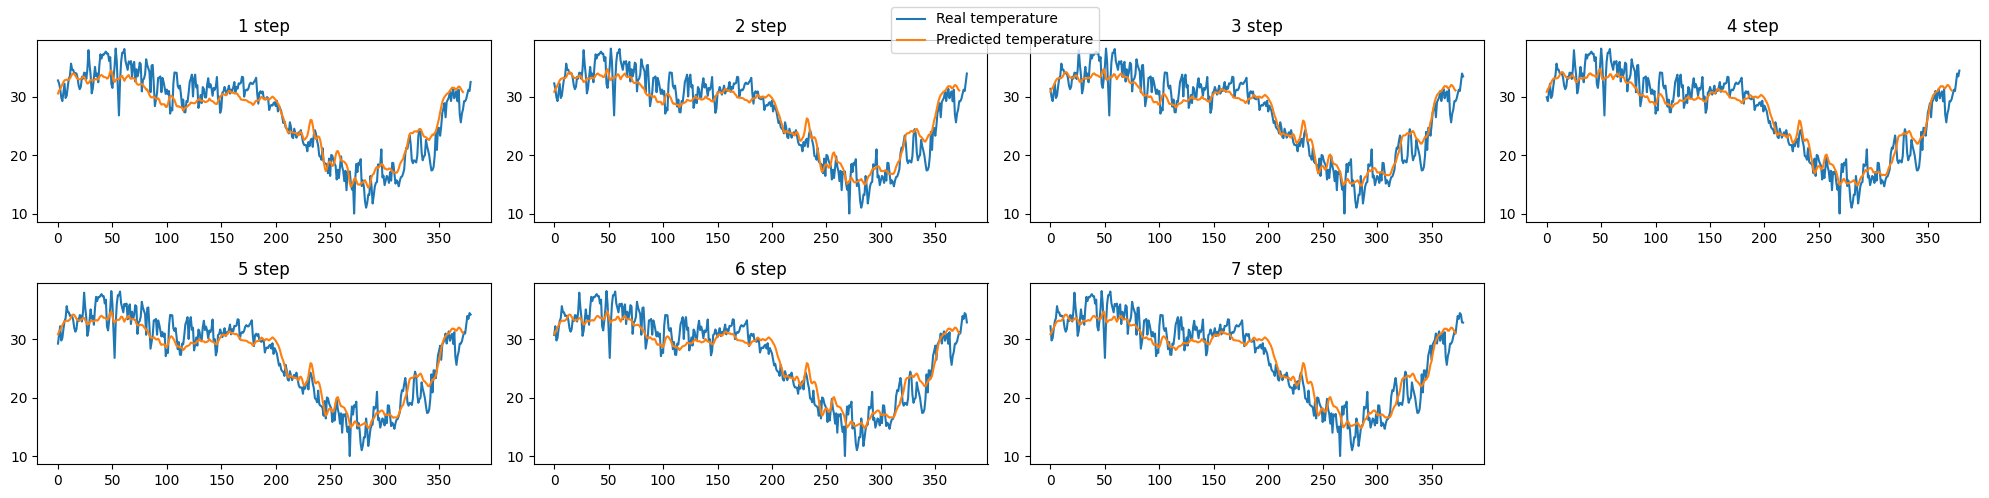

In [39]:
plot_results_by_step(df_test, multi_convlstm_preds)